In [8]:
# ============================================================
# Cellule 1 — Installation et importation des bibliothèques
# ============================================================
# Cette cellule permet d’installer et d’importer toutes les
# bibliothèques nécessaires pour :
# 1) L’augmentation du dataset
# 2) Le découpage train / validation
# 3) L’entraînement du modèle YOLOv8
#
# Le travail est réalisé sur Google Colab
# ============================================================

# --- Installation des dépendances ---
!pip install -q ultralytics opencv-python albumentations matplotlib numpy tqdm pyyaml

# --- Importation des librairies ---
import os
import cv2
import yaml
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from ultralytics import YOLO
import albumentations as A


In [9]:
# ============================================================
# Cellule 2 — Connexion à Google Drive et définition des chemins
# ============================================================
# Cette cellule permet :
# - De connecter Google Drive
# - De définir les chemins du dataset original (images + labels)
# - De définir le dossier de sortie pour le dataset augmenté
#
# Le dataset initial est stocké dans :
# IOT_project/dataset/images
# IOT_project/dataset/labels
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

# --- Chemins du dataset original ---
BASE_PATH = "/content/drive/MyDrive/IOT_project"
DATASET_PATH = os.path.join(BASE_PATH, "dataset")

IMAGES_PATH = os.path.join(DATASET_PATH, "images")
LABELS_PATH = os.path.join(DATASET_PATH, "labels")

# --- Chemins du dataset augmenté ---
AUG_PATH = os.path.join(BASE_PATH, "dataset_augmented")
AUG_IMAGES = os.path.join(AUG_PATH, "images")
AUG_LABELS = os.path.join(AUG_PATH, "labels")

# Création des dossiers s’ils n’existent pas
os.makedirs(AUG_IMAGES, exist_ok=True)
os.makedirs(AUG_LABELS, exist_ok=True)

print(" Google Drive connecté")
print(" Images originales :", IMAGES_PATH)
print(" Labels originaux :", LABELS_PATH)
print(" Images augmentées :", AUG_IMAGES)
print(" Labels augmentés :", AUG_LABELS)


Mounted at /content/drive
 Google Drive connecté
 Images originales : /content/drive/MyDrive/IOT_project/dataset/images
 Labels originaux : /content/drive/MyDrive/IOT_project/dataset/labels
 Images augmentées : /content/drive/MyDrive/IOT_project/dataset_augmented/images
 Labels augmentés : /content/drive/MyDrive/IOT_project/dataset_augmented/labels


In [10]:
DATASET_PATH = "/content/drive/MyDrive/IOT_project/dataset"
IMAGES_PATH = f"{DATASET_PATH}/images"
LABELS_PATH = f"{DATASET_PATH}/labels"

print("Images :", len(os.listdir(IMAGES_PATH)))
print("Labels :", len(os.listdir(LABELS_PATH)))


Images : 127
Labels : 126


In [11]:
import os

FIX_MAP = {
    0: 9,
    1: 5,
    2: 1,
    3: 8,
    4: 4,
    5: 0,
    6: 7,
    7: 3,
    8: 10,
    9: 6,
    10: 2,
    11: 11
}

for file in os.listdir(LABELS_PATH):
    if file.endswith(".txt"):
        path = os.path.join(LABELS_PATH, file)

        with open(path, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()


            old_id = int(float(parts[0]))


            new_id = FIX_MAP[old_id]
            parts[0] = str(new_id)

            new_lines.append(" ".join(parts) + "\n")

        with open(path, "w") as f:
            f.writelines(new_lines)

print("✅ Tous les labels ont été corrigés avec succès")


✅ Tous les labels ont été corrigés avec succès


In [ ]:
#verification
!head -n 5 /content/drive/MyDrive/IOT_project/dataset/labels/*.txt



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
==> /content/drive/MyDrive/IOT_project/dataset/labels/aug_aaa966747f364e37a4dafe51ab3fb754.txt <==
5 0.5 0.46927501131400917 1.0 0.5738038221381074

==> /content/drive/MyDrive/IOT_project/dataset/labels/aug_aaea95971398479d800d011951fc4f8b.txt <==
9 0.5 0.5 1.0 1.0

==> /content/drive/MyDrive/IOT_project/dataset/labels/aug_aaeb98f681ee4b43838042d67d184580.txt <==
9 0.46432383366476776 0.5385474144207644 0.8420475203693251 0.6449340828034731

==> /content/drive/MyDrive/IOT_project/dataset/labels/aug_aaf23c9b4f694bf28fc25d483e880e64.txt <==
1 0.47079681204848084 0.5675207202456852 0.9415936240969617 0.8562462735087137

==> /content/drive/MyDrive/IOT_project/dataset/labels/aug_ab0dbbf0dca24263b3ff17682ad33536.txt <==
0 0.5 0.5 1.0 1.0

==> /content/drive/MyDrive/IOT_project/dataset/labels/aug_ab283f0d3e0048cab8d8402d96838bfe.txt <==
9 0.5355708450078964 0.49126197397708893 0.9058587849140167 0.9796254336833954



In [12]:
# ============================================================
# Cellule 3 — Vérification et nettoyage du dataset
# ============================================================
# Cette cellule permet :
# - De vérifier que chaque image possède un fichier label YOLO
# - D’ignorer automatiquement les images sans annotation
# - De travailler sur un dataset propre et cohérent
#
# Cette étape est essentielle pour éviter les erreurs
# lors de l’augmentation et de l’entraînement YOLO
# ============================================================

valid_images = []

for img in os.listdir(IMAGES_PATH):
    name, ext = os.path.splitext(img)
    label_file = name + ".txt"

    if os.path.exists(os.path.join(LABELS_PATH, label_file)):
        valid_images.append(img)
    else:
        print(f" Image ignorée (pas de label) : {img}")

print(f"\n Nombre total d’images valides : {len(valid_images)}")



 Nombre total d’images valides : 127


In [13]:
# ============================================================
# Cellule 4 — Définition des transformations d’augmentation
# ============================================================
# Cette cellule définit les transformations appliquées
# aux images afin d’augmenter artificiellement le dataset.
#
# Les augmentations sont réalistes et adaptées à la détection
# d’objets (rotation, zoom, luminosité, flou léger, etc.)
#
# IMPORTANT :
# - Les labels YOLO seront ajustés automatiquement
# - Les classes ne sont PAS modifiées
# ============================================================

transform = A.Compose([
    A.Rotate(limit=20, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.2),
    A.RandomScale(scale_limit=0.2, p=0.4),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.15,
        rotate_limit=15,
        p=0.4
    )
], bbox_params=A.BboxParams(
    format='yolo',
    label_fields=['class_labels']
))

print(" Transformations d’augmentation définies")


 Transformations d’augmentation définies


In [14]:
# ============================================================
# Cellule 5 — Application de l’augmentation sur images + labels YOLO
# ============================================================

import cv2
import albumentations as A
import os
import uuid

IMAGES_PATH = "/content/drive/MyDrive/IOT_project/dataset/images"
LABELS_PATH = "/content/drive/MyDrive/IOT_project/dataset/labels"

AUG_PER_IMAGE = 3

# Augmentation pipeline
transform = A.Compose([
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=0,
        p=0.5
    ),
], bbox_params=A.BboxParams(
    format="yolo",
    label_fields=["class_labels"]
))

image_files = [f for f in os.listdir(IMAGES_PATH) if f.endswith(('.jpg', '.png'))]

count = 0

for img_name in image_files:
    img_path = os.path.join(IMAGES_PATH, img_name)
    lbl_path = os.path.join(LABELS_PATH, img_name.rsplit('.', 1)[0] + ".txt")

    if not os.path.exists(lbl_path):
        continue

    image = cv2.imread(img_path)
    if image is None:
        continue

    bboxes = []
    class_ids = []

    with open(lbl_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_ids.append(int(float(parts[0])))
            bboxes.append(list(map(float, parts[1:])))

    if len(bboxes) == 0:
        continue

    for _ in range(AUG_PER_IMAGE):
        augmented = transform(
            image=image,
            bboxes=bboxes,
            class_labels=class_ids
        )

        aug_image = augmented["image"]
        aug_bboxes = augmented["bboxes"]
        aug_classes = augmented["class_labels"]

        new_name = f"aug_{uuid.uuid4().hex}"
        cv2.imwrite(os.path.join(IMAGES_PATH, new_name + ".jpg"), aug_image)

        with open(os.path.join(LABELS_PATH, new_name + ".txt"), "w") as f:
            for cls, box in zip(aug_classes, aug_bboxes):
                f.write(f"{cls} {' '.join(map(str, box))}\n")

        count += 1

print(f"✅ Augmentation terminée : {count} nouvelles images générées")


✅ Augmentation terminée : 366 nouvelles images générées


In [15]:
# ============================================================
# Cellule 6 — Split du dataset en train / validation (YOLOv8)
# ============================================================

import os
import shutil
import random

BASE_PATH = "/content/drive/MyDrive/IOT_project/dataset"

IMAGES_PATH = os.path.join(BASE_PATH, "images")
LABELS_PATH = os.path.join(BASE_PATH, "labels")

TRAIN_IMG = os.path.join(BASE_PATH, "train/images")
TRAIN_LBL = os.path.join(BASE_PATH, "train/labels")
VAL_IMG   = os.path.join(BASE_PATH, "val/images")
VAL_LBL   = os.path.join(BASE_PATH, "val/labels")

# Créer dossiers
for p in [TRAIN_IMG, TRAIN_LBL, VAL_IMG, VAL_LBL]:
    os.makedirs(p, exist_ok=True)

images = [f for f in os.listdir(IMAGES_PATH) if f.endswith(('.jpg', '.png'))]
random.shuffle(images)

split_ratio = 0.8
split_idx = int(len(images) * split_ratio)

train_imgs = images[:split_idx]
val_imgs   = images[split_idx:]

def copy_files(img_list, img_dst, lbl_dst):
    for img in img_list:
        img_src = os.path.join(IMAGES_PATH, img)
        lbl_src = os.path.join(LABELS_PATH, img.rsplit('.', 1)[0] + ".txt")

        if not os.path.exists(lbl_src):
            continue

        shutil.copy(img_src, img_dst)
        shutil.copy(lbl_src, lbl_dst)

copy_files(train_imgs, TRAIN_IMG, TRAIN_LBL)
copy_files(val_imgs, VAL_IMG, VAL_LBL)

print("✅ Split terminé avec succès")
print(f"Images totales     : {len(images)}")
print(f"Train images       : {len(train_imgs)}")
print(f"Validation images  : {len(val_imgs)}")


✅ Split terminé avec succès
Images totales     : 488
Train images       : 390
Validation images  : 98


In [16]:
# ============================================================
# Cellule 7 — Création du fichier data.yaml pour YOLOv8
# ============================================================

import yaml
import os

DATASET_PATH = "/content/drive/MyDrive/IOT_project/dataset"

data = {
    "train": os.path.join(DATASET_PATH, "train/images"),
    "val": os.path.join(DATASET_PATH, "val/images"),
    "nc": 12,
    "names": [
        "1 dinar",
        "10 dinars",
        "10 millimes",
        "100 millimes",
        "2 dinars",
        "20 dinars",
        "20 millimes",
        "200 millimes",
        "5 dinars",
        "50 dinars",
        "50 millimes",
        "500 millimes"
    ]
}

yaml_path = os.path.join(DATASET_PATH, "data.yaml")

with open(yaml_path, "w") as f:
    yaml.dump(data, f, sort_keys=False)

print(" Fichier data.yaml créé avec succès !")
print(" Chemin :", yaml_path)


 Fichier data.yaml créé avec succès !
 Chemin : /content/drive/MyDrive/IOT_project/dataset/data.yaml


In [17]:
train: dataset/train/images
val: dataset/val/images

nc: 12
names:
- 1 dinar
- 10 dinars
- 10 millimes
- 100 millimes
- 2 dinars
- 20 dinars
- 20 millimes
- 200 millimes
- 5 dinars
- 50 dinars
- 50 millimes
- 500 millimes


SyntaxError: invalid syntax (ipython-input-2058221709.py, line 5)

In [ ]:
!rm -rf runs/detect_monnaie


In [18]:
# ============================================================
# Cellule 8 — Entraînement du modèle YOLOv8
# ============================================================

!pip install ultralytics --quiet


In [ ]:
from ultralytics import YOLO
import torch

print("GPU disponible :", torch.cuda.is_available())

model = YOLO("yolov8n.pt")

model.train(
    data="/content/drive/MyDrive/IOT_project/dataset/data.yaml",
    epochs=25,
    imgsz=416,
    batch=4,
    lr0=0.001,
    device="cpu",
    workers=2,
    project="runs",
    name="detect_monnaie",
    patience=10,
    resume=False,
    exist_ok=False,
    verbose=True
)


In [22]:
# ============================================================
# Cellule 8 — Entraînement du modèle YOLOv8 (CPU)
# ============================================================

from ultralytics import YOLO
import torch

print("GPU disponible :", torch.cuda.is_available())

# Charger le modèle YOLOv8 pré-entraîné
model = YOLO("yolov8n.pt")

# Lancer l'entraînement
model.train(
    data="/content/drive/MyDrive/IOT_project/dataset/data.yaml",
    epochs=25,
    imgsz=416,
    batch=4,
    lr0=0.001,
    device="cpu",
    workers=2,
    project="runs",
    name="detect_monnaie",
    patience=10
)


GPU disponible : False
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/IOT_project/dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=olive_leaf_detection4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c1e44722750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.0460

In [25]:
import shutil

shutil.copy(
    "/content/runs/olive_leaf_detection4/weights/best.pt",
    "/content/drive/MyDrive/IOT_project/best.pt"
)

print(" Modèle sauvegardé dans Google Drive")


 Modèle sauvegardé dans Google Drive


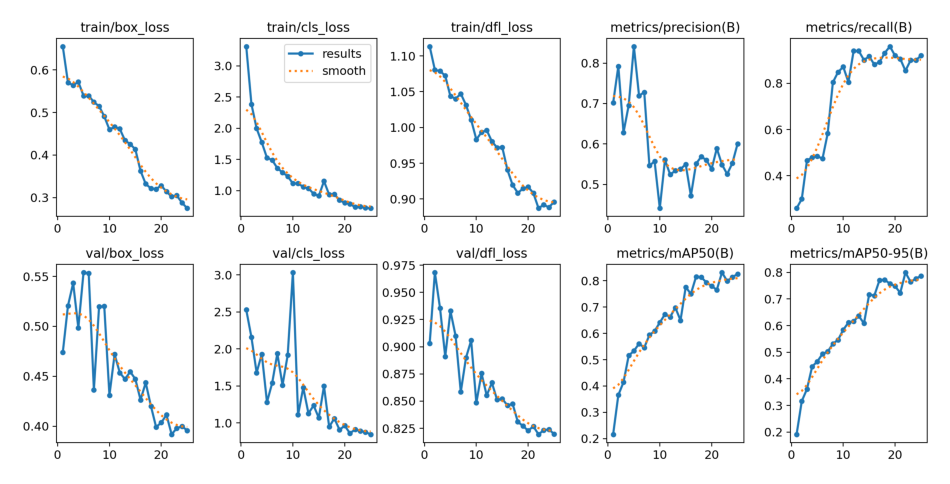

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/runs/olive_leaf_detection4/results.png")
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis("off")
plt.show()


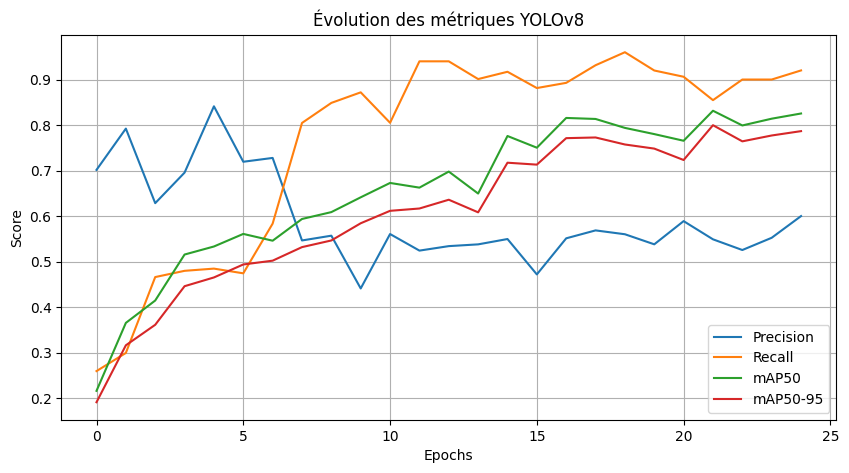

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/runs/olive_leaf_detection4/results.csv")

plt.figure(figsize=(10,5))
plt.plot(df["metrics/precision(B)"], label="Precision")
plt.plot(df["metrics/recall(B)"], label="Recall")
plt.plot(df["metrics/mAP50(B)"], label="mAP50")
plt.plot(df["metrics/mAP50-95(B)"], label="mAP50-95")

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Évolution des métriques YOLOv8")
plt.legend()
plt.grid()
plt.show()
